In [1]:
import numpy as np
import scipy.io as scio

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskElasticNetCV

# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [3]:
data = scio.loadmat('stevenson/data/Stevenson_2011_e1.mat', struct_as_record=False)

In [15]:
data['Subject'][0, 0].Trial[0, 0].HandPos

array([[ 0.00291096, -0.30363264,  0.        ],
       [ 0.00279626, -0.3036988 ,  0.        ],
       [ 0.00267075, -0.30376814,  0.        ],
       ...,
       [-0.02496676, -0.33295615,  0.        ],
       [-0.02449323, -0.33297168,  0.        ],
       [-0.02404612, -0.33297546,  0.        ]])

In [3]:
def get_subject(data, subject_idx):
    subject = data['Subject'][subject_idx, 0]
    return subject

In [4]:
def get_targets(subject):
    # extract trials
    trials = subject.Trial.ravel()
    n_trials = trials.size
    # initialize targets
    targets = np.array([[0, 0, 0]])
    # iterate over trials
    for trial_idx in range(n_trials):
        # grab trial
        trial = trials[trial_idx]
        # extract indices for which target is on
        target_indices = ~np.isnan(trial.TargetPos)
        # grab unique target values
        target = np.unique(trial.TargetPos[target_indices[:, 0]], axis=0)
        # add the new targets on
        targets = np.concatenate((targets, target), axis=0)
    # extract only unique targets
    targets = np.unique(targets[1:, :2], axis=0)
    # get center
    center = np.mean(targets, axis=0)
    return targets, center

In [5]:
def calc_angle(start, end):
    # vector from center to target
    vec = end - start
    # clip any tiny values
    vec[np.isclose(vec, 0)] = 0
    # calculate angle
    angle = np.round(np.arctan2(vec[1], vec[0]) * 180/np.pi)
    # change angle to range [0, 360)
    if angle < 0:
        angle += 360.
    return angle

In [6]:
def get_trial_info(subject, trial_idx):
    targets, center = get_targets(subject)
    ### get trial
    trial = subject.Trial[trial_idx, 0]
    ### get target on indices
    targetPos = trial.TargetPos[:, :2]
    # iterate over target positions
    center_idxs = np.array([], dtype='int')
    target_idxs = np.array([], dtype='int')
    for idx in range(targetPos.shape[0]):
        cur_target = targetPos[idx]
        if not (np.isnan(cur_target[0]) and np.isnan(cur_target[1])):
            if np.all(np.isclose(cur_target, center)):
                center_idxs = np.append(center_idxs, idx)
            else:
                target_idxs = np.append(target_idxs, idx)
    if target_idxs.size == 0:
        return trial, center_idxs, target_idxs, (center, None, None)
    else:
        # extract target
        target = np.unique(targetPos[target_idxs, :], axis=0).ravel()
        ### get reach angle
        angle = calc_angle(center, target)
        return trial, center_idxs, target_idxs, (center, target, angle)

In [7]:
def get_times_for_trial(trial, center_idxs, target_idxs):
    # grab times
    times = trial.Time.ravel()
    # grab times for each segment
    center_times = times[center_idxs]
    target_times = times[target_idxs]
    return center_times, target_times

In [8]:
def get_spikes_for_trial(trial, target_times, dT=(0, 0.2)):
    target_on = target_times[0]
    time_bounds = (target_on - dT[0], target_on + dT[1])
    # now, we grab the spike times
    neurons = trial.Neuron.ravel()
    responses = np.zeros((neurons.size))
    for n_idx, neuron in enumerate(neurons):
        spike_times = neuron.Spike.ravel()
        responses[n_idx] = np.count_nonzero(
            (spike_times >= time_bounds[0]) & (spike_times < time_bounds[1])
        )
    return responses

In [9]:
def get_all_responses(subject, dT=(0, 0.2)):
    targets, center = get_targets(subject)
    # number of trials
    n_trials = subject.Trial.size
    # number of Neurons
    n_neurons = subject.Trial[0,0].Neuron.size
    # set up stim matrix and response matrix
    stimuli = np.zeros(n_trials)
    responses = np.zeros((n_trials, n_neurons))
    skipped_trials = np.array([], dtype='int')
    # iterate over trials
    for trial_idx in range(n_trials):
        trial, center_idxs, target_idxs, (center, target, angle) = get_trial_info(subject, trial_idx)
        if target is None:
            skipped_trials = np.append(skipped_trials, trial_idx)
        else:
            # toss stim in matrix
            stimuli[trial_idx] = angle
            # grab responses around relevant window
            center_times, target_times = get_times_for_trial(trial, center_idxs, target_idxs)
            responses[trial_idx, :] = get_spikes_for_trial(trial, target_times, dT=dT)/(dT[1] - dT[0])
    # delete trials which had no stimulus
    stimuli = np.delete(stimuli, skipped_trials)
    responses = np.delete(responses, skipped_trials, axis=0)
    return stimuli, responses

In [10]:
def angles_to_design(stimuli):
    design_matrix = np.zeros((stimuli.size, 2))
    for stim_idx, stim in enumerate(stimuli):
        design_matrix[stim_idx] = np.array([np.cos(stim), np.sin(stim)])
    return design_matrix

In [11]:
subject = get_subject(data, 1)
dT = (0, 0.2)
stimuli, responses = get_all_responses(subject, dT=dT)
design = angles_to_design(stimuli)
# optional: only choose neurons with firing rate > 0.2 Hz
responsive_neuron_idx = np.mean(responses, axis=0) > 1
responses = responses[:, responsive_neuron_idx]
# square root transform
responses = np.sqrt(responses * (dT[1] - dT[0]))

# OLS Approach

In [12]:
def tuning_model(design, responses, return_cosine=False):
    ols = LinearRegression(fit_intercept=True)
    ols.fit(design, responses)
    #ols = MultiTaskElasticNetCV(
    #    l1_ratio=[0.01, .1, .5, .7, .9, .95, .99, 1],
    #    normalize=True, 
    #    tol=1e-7, 
    #    max_iter = 100000
    #)
    ols.fit(design, responses)
    # extract model
    b0 = ols.intercept_
    c1 = ols.coef_[:, 0]
    c2 = ols.coef_[:, 1]
    if return_cosine:
        # transform to tuning curve model
        theta_star = np.arctan2(c2, c1) * (180/np.pi)
        theta_star[theta_star < 0] += 360
        b1 = (c2 - c1)/(np.sin(theta_star) - np.cos(theta_star))
        return b0, b1, theta_star
    else:
        return b0, c1, c2

In [13]:
def tuning_coupling_model(design, responses, return_cosine=False):
    n_neurons = responses.shape[1]
    b0 = np.zeros(n_neurons)
    c1 = np.zeros(n_neurons)
    c2 = np.zeros(n_neurons)
    # iterate over neurons and form the corresponding design matrix
    for neuron in range(n_neurons):
        X = np.concatenate((design, np.delete(responses, neuron, axis=1)), axis=1)
        y = responses[:, neuron]
        ols = LinearRegression(fit_intercept=True)
        ols.fit(X, y)
        #ols = ElasticNetCV(
        #    l1_ratio=[0.01, .1, .5, .7, .9, .95, .99, 1],
        #    normalize=True, 
        #    tol=1e-7, 
        #    max_iter = 100000
        #)
        ols.fit(X, y)
        # store fits
        b0[neuron] = ols.intercept_
        c1[neuron] = ols.coef_[0]
        c2[neuron] = ols.coef_[1]
    if return_cosine:
        # transform to tuning curve model
        theta_star = np.arctan2(c2, c1) * (180/np.pi)
        theta_star[theta_star < 0] += 360
        b1 = (c2 - c1)/(np.sin(theta_star) - np.cos(theta_star))
        return b0, b1, theta_star
    else:
        return b0, c1, c2

In [14]:
# perform tuning model
b0, c1, c2 = tuning_model(design, responses)
# perform tuning+coupling model
b0_tc, c1_tc, c2_tc = tuning_coupling_model(design, responses)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


## Tuning curves

In [57]:
#def plot_tuning_curve(idx, b0, b1, theta_star, ax=None, color='b'):
#    if ax is None:
#        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
#    thetas = np.linspace(0, 360, 1000)
#    ax.plot(thetas, b1[idx] * np.cos((np.pi/180) * (thetas - theta_star[idx])), color=color)
    

In [21]:
def plot_tuning_curve(idx, c1, c2, ax=None, color='b'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    thetas = np.linspace(0, 360, 1000)
    ax.plot(thetas, c1 * np.cos(np.pi/180 * thetas) + c2 * np.sin(np.pi/180 * thetas), color=color, linewidth=5)

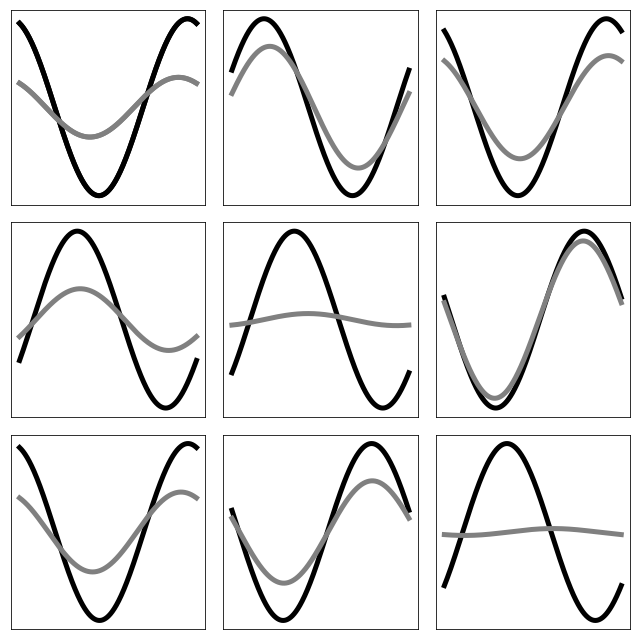

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
plot_tuning_curve(1, c1[1], c2[1], ax=axes[0,0], color='k')
plot_tuning_curve(1, c1_tc[1], c2_tc[1], ax=axes[0,0], color='gray')
plot_tuning_curve(10, c1[10], c2[10], ax=axes[0,1], color='k')
plot_tuning_curve(10, c1_tc[10], c2_tc[10], ax=axes[0,1], color='gray')
plot_tuning_curve(1, c1[1], c2[1], ax=axes[0,0], color='k')
plot_tuning_curve(1, c1_tc[1], c2_tc[1], ax=axes[0,0], color='gray')
plot_tuning_curve(16, c1[16], c2[16], ax=axes[0,2], color='k')
plot_tuning_curve(16, c1_tc[16], c2_tc[16], ax=axes[0,2], color='gray')
plot_tuning_curve(24, c1[24], c2[24], ax=axes[1,0], color='k')
plot_tuning_curve(24, c1_tc[24], c2_tc[24], ax=axes[1,0], color='gray')
plot_tuning_curve(24, c1[26], c2[26], ax=axes[1,1], color='k')
plot_tuning_curve(24, c1_tc[26], c2_tc[26], ax=axes[1,1], color='gray')
plot_tuning_curve(50, c1[50], c2[50], ax=axes[1,2], color='k')
plot_tuning_curve(50, c1_tc[50], c2_tc[50], ax=axes[1,2], color='gray')
plot_tuning_curve(59, c1[59], c2[59], ax=axes[2,0], color='k')
plot_tuning_curve(59, c1_tc[59], c2_tc[59], ax=axes[2,0], color='gray')
plot_tuning_curve(72, c1[72], c2[72], ax=axes[2,1], color='k')
plot_tuning_curve(72, c1_tc[72], c2_tc[72], ax=axes[2,1], color='gray')
plot_tuning_curve(54, c1[54], c2[54], ax=axes[2,2], color='k')
plot_tuning_curve(54, c1_tc[54], c2_tc[54], ax=axes[2,2], color='gray')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
#axes[2, 1].set_xlabel(r'\textbf{Direction}', fontsize=50, labelpad=10)
plt.tight_layout()
plt.savefig('fig1a.pdf')

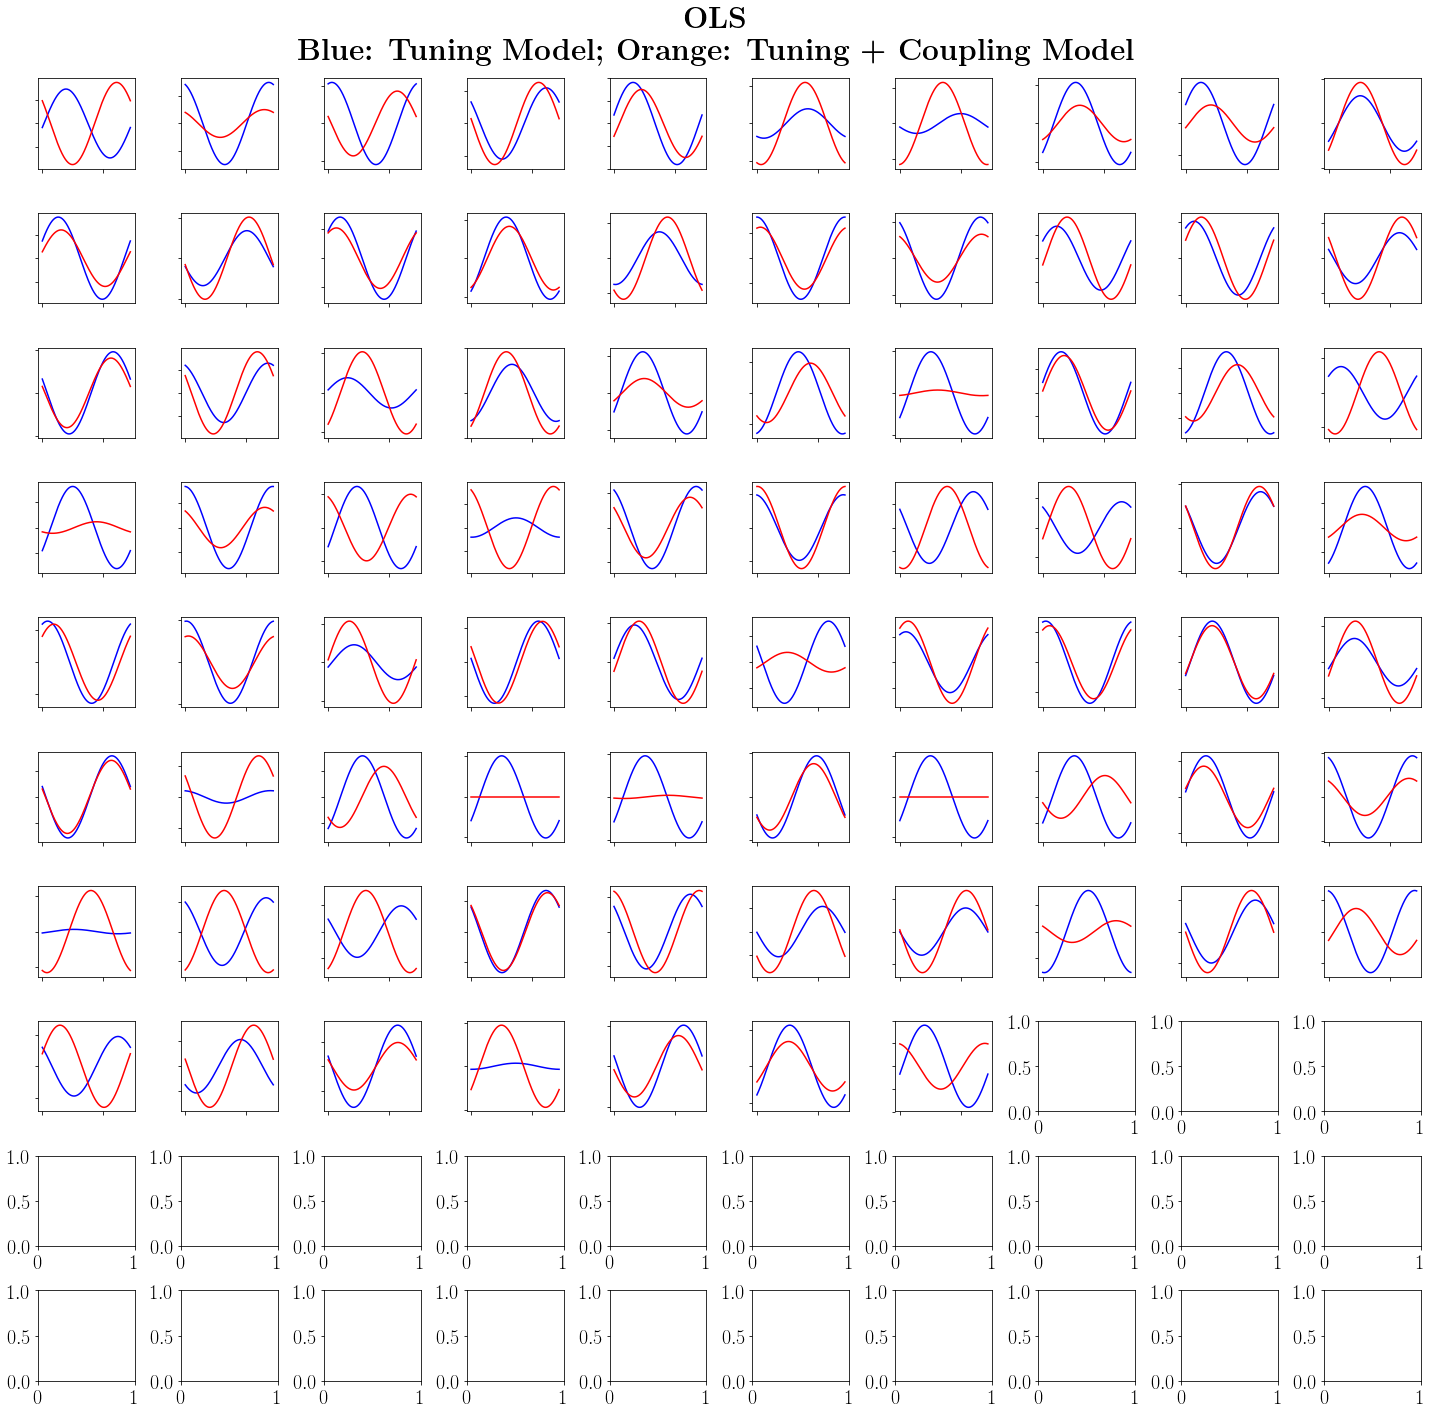

In [16]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes_list = axes.ravel()
# plot tuning model
for idx in range(responses.shape[1]):
    ax = axes_list[idx]
    plot_tuning_curve(idx, c1[idx], c2[idx], ax=ax, color='b')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# plot tuning+coupling model
for idx in range(responses.shape[1]):
    ax = axes_list[idx]
    plot_tuning_curve(idx, c1_tc[idx], c2_tc[idx], ax=ax, color='r')

fig.suptitle(r'\textbf{OLS}' '\n' r'\textbf{Blue: Tuning Model; Orange: Tuning + Coupling Model}', fontsize=30)
plt.tight_layout(rect=[0, 0.0, 1, 0.94])
#plt.savefig('dream_ols.pdf')

# Tuning Modulation and Tuning Preference

In [49]:
def equalize(ax):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

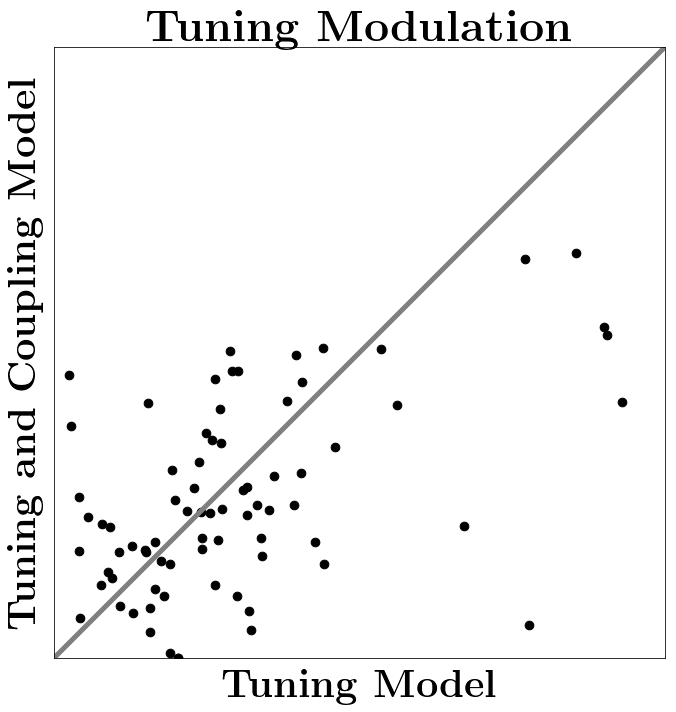

In [66]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

thetas = np.linspace(0, 360, 5000)
modulation_t = np.zeros((responses.shape[1]))
modulation_tc = np.zeros((responses.shape[1]))
preferred_t = np.zeros((responses.shape[1]))
preferred_t_alt = np.zeros((responses.shape[1]))
preferred_tc = np.zeros((responses.shape[1]))
preferred_tc_alt = np.zeros((responses.shape[1]))

for neuron in range(responses.shape[1]):
    responses_t = c1[neuron] * np.cos(np.pi/180 * thetas) + c2[neuron] * np.sin(np.pi/180 * thetas)
    responses_tc = c1_tc[neuron] * np.cos(np.pi/180 * thetas) + c2_tc[neuron] * np.sin(np.pi/180 * thetas)
    modulation_t[neuron] = np.max(responses_t) - np.min(responses_t)
    modulation_tc[neuron] = np.max(responses_tc) - np.min(responses_tc)
    preferred_t[neuron] = thetas[np.argmax(responses_t)]
    preferred_t_alt[neuron] = np.arctan2(c2[neuron], c1[neuron]) * (180/np.pi)
    preferred_tc[neuron] = thetas[np.argmax(responses_tc)]
    preferred_tc_alt[neuron] = np.arctan2(c2_tc[neuron], c1_tc[neuron]) * (180/np.pi)

axes.scatter(modulation_t, modulation_tc, color='k', s=75)
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlim([0, 0.5])
axes.set_ylim([0.,0.5])
axes.plot(axes.get_xlim(), axes.get_ylim(), color='gray', linewidth=5)
axes.set_xlabel(r'\textbf{Tuning Model}', fontsize=40, labelpad=10)
axes.set_ylabel(r'\textbf{Tuning and Coupling Model}', fontsize=40, labelpad=10)
axes.set_title(r'\textbf{Tuning Modulation}', fontsize=45)
equalize(axes)
plt.tight_layout()
plt.savefig('fig1a-2.pdf')

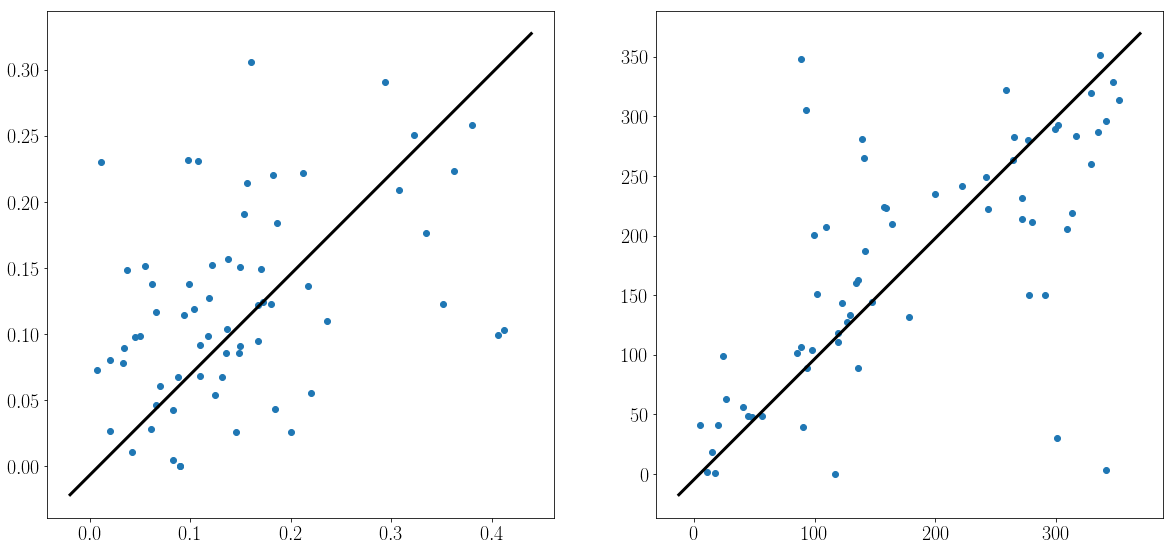

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

thetas = np.linspace(0, 360, 5000)
modulation_t = np.zeros((responses.shape[1]))
modulation_tc = np.zeros((responses.shape[1]))
preferred_t = np.zeros((responses.shape[1]))
preferred_t_alt = np.zeros((responses.shape[1]))
preferred_tc = np.zeros((responses.shape[1]))
preferred_tc_alt = np.zeros((responses.shape[1]))

for neuron in range(responses.shape[1]):
    responses_t = c1[neuron] * np.cos(np.pi/180 * thetas) + c2[neuron] * np.sin(np.pi/180 * thetas)
    responses_tc = c1_tc[neuron] * np.cos(np.pi/180 * thetas) + c2_tc[neuron] * np.sin(np.pi/180 * thetas)
    modulation_t[neuron] = np.max(responses_t) - np.min(responses_t)
    modulation_tc[neuron] = np.max(responses_tc) - np.min(responses_tc)
    preferred_t[neuron] = thetas[np.argmax(responses_t)]
    preferred_t_alt[neuron] = np.arctan2(c2[neuron], c1[neuron]) * (180/np.pi)
    preferred_tc[neuron] = thetas[np.argmax(responses_tc)]
    preferred_tc_alt[neuron] = np.arctan2(c2_tc[neuron], c1_tc[neuron]) * (180/np.pi)

axes[0].scatter(modulation_t, modulation_tc)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), color='k', linewidth=3)
equalize(axes[0])

axes[1].scatter(preferred_t, preferred_tc)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), color='k', linewidth=3)
equalize(axes[1])

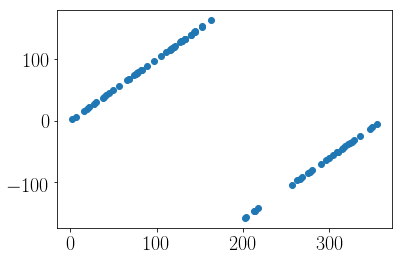

In [76]:
plt.scatter(preferred_t, preferred_t_alt)

# PyGLMnet

In [42]:
from sklearn.preprocessing import StandardScaler
from pyglmnet import GLM

In [43]:
subject = get_subject(data, 1)
stimuli, responses = get_all_responses(subject)
design = angles_to_design(stimuli)

In [44]:
def tuning_model_GLM(design, responses):
    n_neurons = responses.shape[1]
    b0 = np.zeros(n_neurons)
    c1 = np.zeros(n_neurons)
    c2 = np.zeros(n_neurons)
    for neuron in range(n_neurons):
        #scaler = StandardScaler()
        #design = scaler.fit(design)
        glm = GLM(distr='poisson', alpha=0.)
        glm.fit(design, responses[:, neuron])
        # extract fit
        fit = glm.fit_[0]
        # extract model
        b0[neuron] = fit['beta0']
        c1[neuron] = fit['beta'][0]
        c2[neuron] = fit['beta'][1]
    # transform to tuning curve model
    theta_star = np.arctan2(c2, c1) * (180/np.pi)
    theta_star[theta_star < 0] += 360
    b1 = (c2 - c1)/(np.sin(theta_star) - np.cos(theta_star))
    # get responsive cells
    responsive_indices = np.argwhere(b0 != 0).ravel()
    return b0, b1, theta_star, responsive_indices

In [45]:
def tuning_coupling_model_GLM(design, responses):
    n_neurons = responses.shape[1]
    b0 = np.zeros(n_neurons)
    c1 = np.zeros(n_neurons)
    c2 = np.zeros(n_neurons)
    for neuron in range(n_neurons):
        X = np.concatenate((design, np.delete(responses, neuron, axis=1)), axis=1)
        y = responses[:, neuron]
        glm = GLM(distr='poisson', alpha=0.)
        glm.fit(design, responses[:, neuron])
        fit = glm.fit_[0]
        # store fits
        b0[neuron] = fit['beta0']
        c1[neuron] = fit['beta'][0]
        c2[neuron] = fit['beta'][1]
    # get responsive cells
    responsive_indices = np.argwhere(b0 != 0).ravel()
    # transform to tuning curve model
    theta_star = np.arctan2(c2, c1) * (180/np.pi)
    theta_star[theta_star < 0] += 360
    b1 = (c2 - c1)/(np.sin(theta_star) - np.cos(theta_star))
    return b0, b1, theta_star, responsive_indices

In [46]:
b0, b1, theta_star, responsive_indices = tuning_model_GLM(design, responses)
b0_tc, b1_tc, theta_star_tc, responsive_indices_tc = tuning_coupling_model_GLM(design, responses)

In [39]:
def plot_tuning_curve(idx, b0, b1, theta_star, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    thetas = np.linspace(0, 360, 1000)
    ax.plot(thetas, b1[idx] * np.cos((np.pi/180) * (thetas - theta_star[idx])))

NameError: name 'store_responsive_indices' is not defined

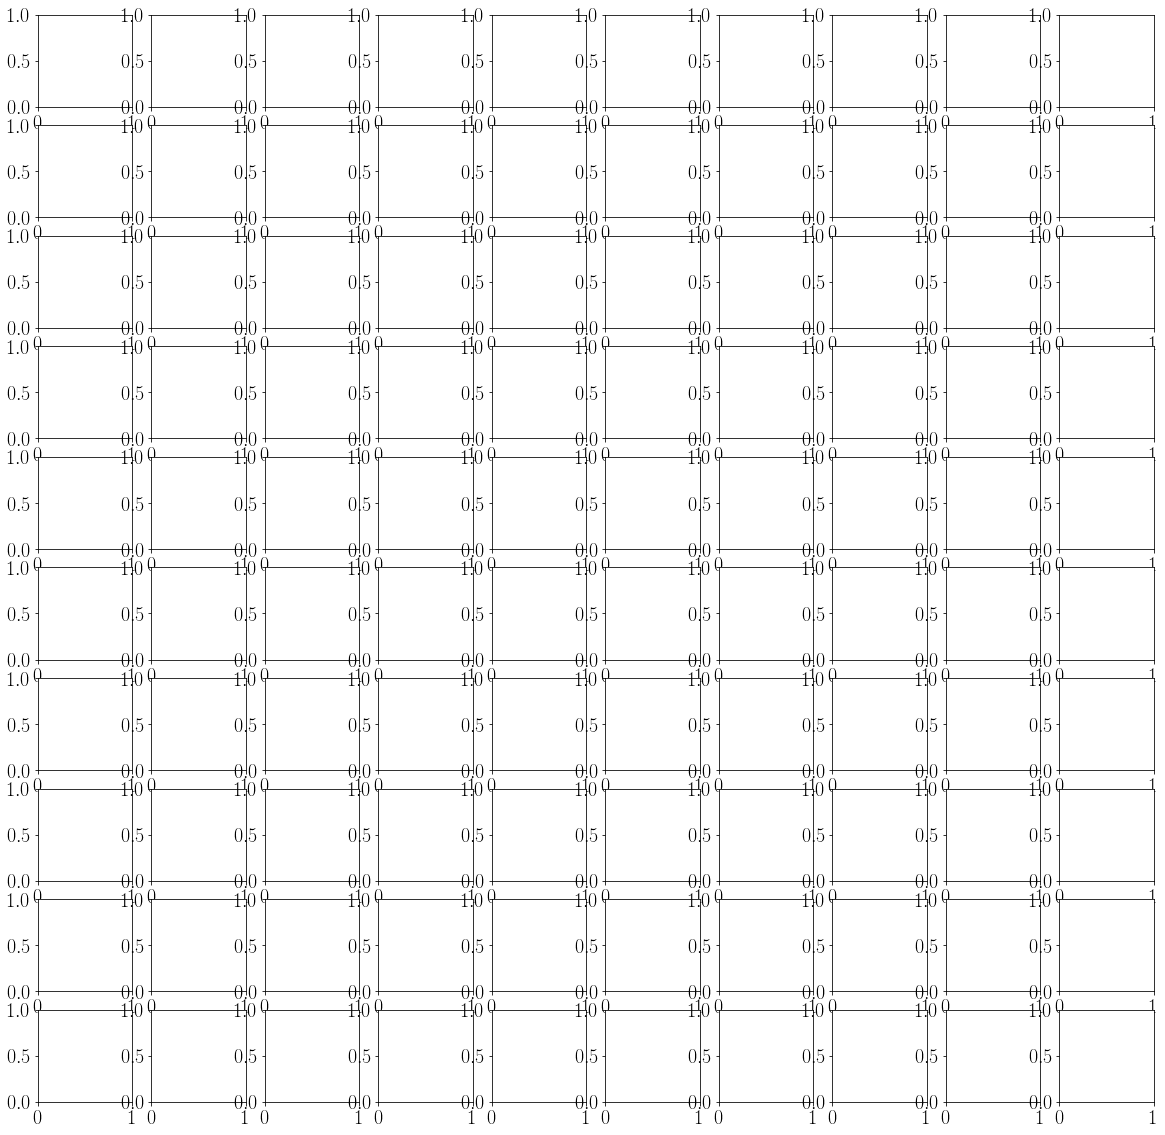

In [40]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes_list = axes.ravel()

# plot tuning model
for idx, neuron_idx in enumerate(store_responsive_indices):
    ax = axes_list[idx]
    plot_tuning_curve(neuron_idx, b0, b1, theta_star, ax=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# plot tuning+coupling model
for idx, neuron_idx in enumerate(store_responsive_indices):
    ax = axes_list[idx]
    plot_tuning_curve(neuron_idx, b0_tc, b1_tc, theta_star_tc, ax=ax)

axes[-1, -1].axis('off')
axes[-1, -2].axis('off')
axes[-1, -3].axis('off')
axes[-1, -4].axis('off')
axes[-1, -5].axis('off')
fig.suptitle(r'\textbf{GLM}' '\n' r'\textbf{Blue: Tuning Model; Orange: Tuning + Coupling Model}', fontsize=30)
plt.tight_layout(rect=[0, 0.0, 1, 0.94])
plt.savefig('dream_glm.pdf')

In [26]:
responsive_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

In [27]:
np.sqrt(180)

13.416407864998739

In [155]:
thetastar[0]

74.68106432760655

In [168]:
thetas = np.linspace(0, 360, 1000) * np.pi/180
ruff = np.zeros((thetas.size, 2))
ruff[:, 0] = np.cos(thetas)
ruff[:, 1] = np.sin(thetas)
pew = glm.predict(ruff)

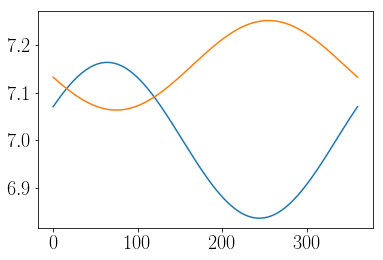

In [169]:
plt.plot(thetas * 180/np.pi, pew[0])
plot_tuning_curve(0)